In [219]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from collections import Counter

#https://mmas.github.io/analyze-apache-access-log-pandas

In [220]:
csv_path_analysis = '/media/joeymeyer/860-evo-ubuntu/Data/caves_org/caves_analysis.csv'
df = pd.read_csv(csv_path_analysis)
df = df.drop(columns=['Unnamed: 0'])
df.shape

(3835335, 8)

The cells below define the parse_datetime function and applies it to the date_time column of that dataframe.

In [221]:
def parse_datetime(x):
    '''
    Parses datetime with timezone formatted as:
        `[day/month/year:hour:minute:second zone]`

    Example:
        `>>> parse_datetime('13/Nov/2015:11:45:42 +0000')`
        `datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)`

    Due to problems parsing the timezone (`%z`) with `datetime.strptime`, the
    timezone will be obtained using the `pytz` library.
    '''
    dt = datetime.strptime(x.split()[0], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

In [222]:
df['date_time'] = df['date_time'].apply(parse_datetime)

In [223]:
df['port'].value_counts()

80     2744867
443    1090468
Name: port, dtype: int64

Port 80 is public (http). Port 443 is secure (https).

In [224]:
print(f"Unique IP addresses: {df['ip_address'].unique().size}")
print(f"Total traffic: {df.shape[0]}")
print(f"Http requests per user: {df.shape[0]/df['ip_address'].unique().size:.2}")

Unique IP addresses: 548164
Total traffic: 3835335
Http requests per user: 7.0


In [225]:
print(f'''Start Date: {min(df['date_time'])}
End Date: {max(df['date_time'])}''')

Start Date: 2019-05-12 06:43:03+00:40
End Date: 2020-05-13 21:46:34+00:40


In [226]:
df['referrer'].value_counts()[:10].divide(df.referrer.count())

-                                                                                              0.313762
https://www.google.com/                                                                        0.045779
https://caves.org/region/rmr/index.php/contact                                                 0.028038
http://caves.org/                                                                              0.022005
https://caves.org/nss-business/publications/JCKS/Bulletin/Bulletin.shtml                       0.008343
http://www.caves.org/grotto/slgrotto/phpbb2/login.php?redirect=profile.php&mode=editprofile    0.005492
https://caves.org/                                                                             0.004564
http://caves.org/grotto/slgrotto/phpbb2/login.php?redirect=posting.php&mode=newtopic&f=6       0.003810
http://www.caves.org/grotto/slgrotto/phpbb2/index.php                                          0.002448
https://caves.org                                               

* 46% of traffic are from google searches 
* 31% of traffic is from direct visitors
* 3% are from Rocky Mountain Region
* 2% are from visiting pages from caves.org
* 1% is from the JCKS Bulletin

In [227]:
ref_null = df[df['referrer'] == "-"]
ref = df[df['referrer'] != "-"]

print(f"""Of {df.shape[0]} human visits to caves.org, {ref_null.shape[0]} are direct visits ({ref_null.shape[0]/df.shape[0]:.2%})
and {ref.shape[0]} were referred ({ref.shape[0]/df.shape[0]:.2%}).""")

Of 3835335 human visits to caves.org, 1203268 are direct visits (31.37%)
and 2632067 were referred (68.63%).


In [228]:
#direct
ref_null['resource'].value_counts()[:20].divide(ref_null.resource.count())

/                                             0.154255
/grotto/flittermouse/wp-login.php             0.130565
/info/                                        0.118127
/section/commelect/DUSI/openmag/src/gfx/      0.050112
/pub/journal/PDF/V67/v67n3-Index.pdf          0.037435
/grotto/slgrotto/phpbb2/rss.php               0.037308
/region/nro/necaver_index3.html               0.027380
/pub/journal/PDF/V74/cave-74-02-221.pdf       0.023669
/project/                                     0.020310
/committee/salons/ballads/Music/              0.015351
/info/NSS_Contacts.pdf                        0.007227
/committee/salons/ballads/Music/2005/         0.006574
/grotto/sligo/index.htm                       0.005895
/section/vertical/nh/50/knotrope.html         0.005718
/grotto/slgrotto/phpbb2/viewtopic.php         0.005386
/WNS/                                         0.003779
/section/asha/                                0.003703
/section/vertical/nh/50/knotrope-hold.html    0.003647
/grotto/sc

* 15% of traffic are from direct visits to caves.org/
* 13% Flittermouse Grotto
* 12% caves.org/info
* 4% a PDF of JCKS index (lots of notable names)
* 4% Salt Lake Grotto
* 3% Northeast Regional Organization
* 2% JCKS article PDF
* 1.5% cave ballads
* more see above


In [229]:
#referred
ref['resource'].value_counts()[10:30].divide(ref.resource.count())

/                                                                 0.025728
/section/vertical/nh/50/knotrope-hold.html                        0.004356
/committee/i-o/grottos/grottos.shtml                              0.004221
/committee/i-o/grottos/new_grotto_page-v2.shtml                   0.003874
/grotto/sag/                                                      0.002543
/info/events.shtml                                                0.002136
/info/NSS_Contacts.pdf                                            0.001815
/pub/journal/                                                     0.001783
/pub/aca/accident_search.shtml                                    0.001695
/grotto/sewaneemountaingrotto/cavefest.html                       0.001519
/grotto/slgrotto/phpbb2/viewonline.php                            0.001415
/nss-business/for_members.shtml                                   0.001413
/search.shtml                                                     0.001353
/About_the_NSS.shtml     

* ~60% of traffic is referred from Salt Lake Grotto (excluded from view)
* 2.6% from caves.org/
* <1%: vertical section, IO list, Shasta Area Grotto, Events, NSS Contacts PDF, JCKS, ACA, CaveFest, etc (see above)

In [230]:
slg_ref = df[df.referrer.str.contains("slg", na=False)]
slg_ref['resource'].value_counts()[:5].divide(ref.resource.count())

/grotto/slgrotto/phpbb2/viewtopic.php    0.196780
/grotto/slgrotto/phpbb2/viewforum.php    0.126281
/grotto/slgrotto/phpbb2/profile.php      0.121634
/grotto/slgrotto/phpbb2/login.php        0.041129
/grotto/slgrotto/phpbb2/index.php        0.037481
Name: resource, dtype: float64

Since Salt Lake Grotto drives a majority of referred traffic, I wanted to see what they were referring to. The traffic is going to other SLG pages and not to caves.org.

In [231]:
google = df[df['referrer'] == "https://www.google.com/"]
google['resource'].value_counts()[:10].divide(google.resource.count())

/                                                                      0.169149
/section/vertical/nh/50/knotrope-hold.html                             0.045067
/grotto/sewaneemountaingrotto/cavefest.html                            0.018677
/info/events.shtml                                                     0.016974
/pub/journal/                                                          0.013380
/section/vertical/nh/49/cthsc/cthsc.html                               0.012577
/grotto/ccg/docs/checklists/Checklist%20of%20Caving%20Equipment.pdf    0.011574
/committee/i-o/grottos/new_grotto_page-v2.shtml                        0.010817
/pub/journal/PDF/v71/cave-71-01-100.pdf                                0.009085
/safety/safety.shtml                                                   0.008328
Name: resource, dtype: float64

Traffic from Google accounts for 46% of referred traffic. Here is the breakdown of that traffic:
* 17% caves.org/
* 5% vertical section
* 2%: Cave Fest, Events
* 1%: see above

In [232]:
print(df.user_agent.value_counts()[:10])

Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36                                                                       302208
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) Gecko/20100101 Firefox/40.1              246042
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20100101 Firefox/36.0                     175025
Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62.0) Gecko/20100101 Firefox/62.0                                                                                                              140847
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20130401 Firefox/31.0              129027
Mozilla/5.0 (Windows NT 6.1) AppleW

Top two browsers used are Windows Chrome and Linux Firefox.

The cells below apply a function to extract the month, day of the week, and hour from the date_time column, then plots the normalized data. There doesn't appear to be any significance to the day of the week or anything unusual about the hours of activity. There is noticeable spike in website visits in July and peaks in August.

In [233]:
df['month'] = df['date_time'].apply(lambda x: x.month)
months = df.groupby('month')['ip_address'].agg(len)
months = months.divide(months.sum())
months

month
1     0.063897
2     0.061226
3     0.054179
4     0.055274
5     0.048313
6     0.057391
7     0.164014
8     0.258371
9     0.118137
10    0.031767
11    0.049059
12    0.038373
Name: ip_address, dtype: float64

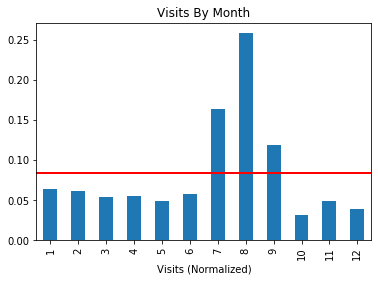

In [234]:
months.plot(kind='bar')
plt.axhline(months.mean(), color='red', linewidth=2)
plt.title('Visits By Month')
plt.xlabel('Visits (Normalized)')
plt.show()

In [235]:
df['weekday'] = df['date_time'].apply(lambda x: x.weekday())
weekdays = df.groupby('weekday')['ip_address'].agg(len)
weekdays = weekdays.divide(weekdays.sum())
weekdays

weekday
0    0.133937
1    0.136638
2    0.152792
3    0.132570
4    0.155071
5    0.151201
6    0.137791
Name: ip_address, dtype: float64

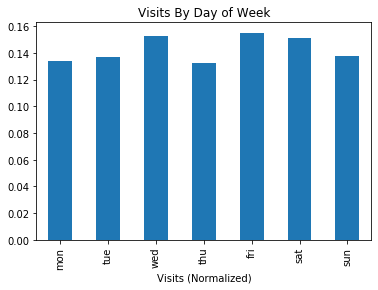

In [236]:
weekdays.index = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
weekdays.plot(kind='bar')
plt.title('Visits By Day of Week')
plt.xlabel('Visits (Normalized)')
plt.show()

In [237]:
df['hour'] = df['date_time'].apply(lambda x: x.hour)
hours = df.groupby('hour')['ip_address'].agg(len)
hours = hours.divide(hours.sum())
hours

hour
0     0.042039
1     0.036544
2     0.034531
3     0.035564
4     0.032935
5     0.031765
6     0.033163
7     0.036273
8     0.039007
9     0.043783
10    0.045324
11    0.043777
12    0.044005
13    0.044917
14    0.045822
15    0.045058
16    0.045205
17    0.045026
18    0.046514
19    0.046336
20    0.045672
21    0.047644
22    0.045692
23    0.043404
Name: ip_address, dtype: float64

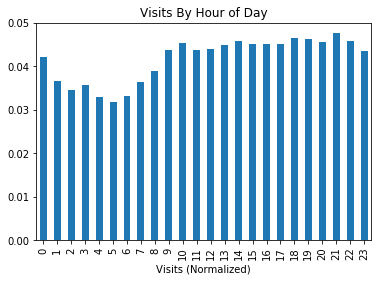

In [238]:
hours.plot(kind='bar')
plt.title('Visits By Hour of Day')
plt.xlabel('Visits (Normalized)')
plt.show()

The cells below define several subsets of the main dataframe--mainly looking at the months of July, August, and September (those are the 3 months with significantly higher traffic) divided by referred and direct traffic. It creates a series of dictionary based on the top 20 websites by normalized visit value.

Since Salt Lake City grotto makes up the majority of referred traffic, we're looking at the resources for direct traffic, by counting the resource urls to determine frequency. A subset of the list is selected if a resource url appears in the top 20 for all four categories: all, July, August, and September.

Another array of dictionaries is created for each category for the targeted list of resources urls as keys and normalized visit as values.

In [239]:
july = df.query('month == 7')
july_direct = july[july['referrer'] == "-"]
jul_ref = july[july['referrer'] != "-"]
august = df.query('month == 8')
aug_ref = august[august['referrer'] != "-"]
aug_direct = august[august['referrer'] == "-"]
september = df.query('month == 8')
sep_ref = september[september['referrer'] != "-"]
sep_direct = september[september['referrer'] == "-"]

all_dir_dic = dict(ref_null['resource'].value_counts()[:20].divide(ref_null.resource.count()))
jul_dir_dic = dict(july_direct['resource'].value_counts()[:20].divide(july_direct.resource.count()))
aug_dir_dic = dict(aug_direct['resource'].value_counts()[:20].divide(aug_direct.resource.count()))
sep_dir_dic = dict(sep_direct['resource'].value_counts()[:20].divide(sep_direct.resource.count()))
dir_dicts = [all_dir_dic, jul_dir_dic, aug_dir_dic, sep_dir_dic]

all_ref_dic = dict(ref['resource'].value_counts()[:20].divide(ref.resource.count()))
jul_ref_dic = dict(july_ref['resource'].value_counts()[:20].divide(july_ref.resource.count()))
aug_ref_dic = dict(aug_ref['resource'].value_counts()[:20].divide(aug_ref.resource.count()))
sep_ref_dic = dict(sep_ref['resource'].value_counts()[:20].divide(sep_ref.resource.count()))
ref_dicts = [all_ref_dic, jul_ref_dic, aug_ref_dic, sep_ref_dic]

In [240]:
urls = []
for dic in dir_dicts:
    for url in dic.keys():
        urls.append(url)

In [241]:
count = Counter(urls)
count

Counter({'/': 4,
         '/grotto/flittermouse/wp-login.php': 4,
         '/info/': 4,
         '/section/commelect/DUSI/openmag/src/gfx/': 1,
         '/pub/journal/PDF/V67/v67n3-Index.pdf': 2,
         '/grotto/slgrotto/phpbb2/rss.php': 4,
         '/region/nro/necaver_index3.html': 4,
         '/pub/journal/PDF/V74/cave-74-02-221.pdf': 4,
         '/project/': 1,
         '/committee/salons/ballads/Music/': 1,
         '/info/NSS_Contacts.pdf': 4,
         '/committee/salons/ballads/Music/2005/': 4,
         '/grotto/sligo/index.htm': 4,
         '/section/vertical/nh/50/knotrope.html': 4,
         '/grotto/slgrotto/phpbb2/viewtopic.php': 2,
         '/WNS/': 4,
         '/section/asha/': 1,
         '/section/vertical/nh/50/knotrope-hold.html': 4,
         '/grotto/sccg/sccg.php': 3,
         '/grotto/timpgrotto/caves/': 1,
         '/brochure/brochurelog.txt': 3,
         '/pub/journal/': 3,
         '/survey/ics/wp-admin/admin-ajax.php': 3,
         '/conservancy/gsp/index.shtml

In [242]:
url_list=[]
for url in count:
    if count[url] >= 3 and "ajax" not in url and "brochue" not in url:
        url_list.append(url)
url_list.remove('/brochure/brochurelog.txt')
url_list.remove('/section/vertical/nh/50/knotrope.html')
url_list

['/',
 '/grotto/flittermouse/wp-login.php',
 '/info/',
 '/grotto/slgrotto/phpbb2/rss.php',
 '/region/nro/necaver_index3.html',
 '/pub/journal/PDF/V74/cave-74-02-221.pdf',
 '/info/NSS_Contacts.pdf',
 '/committee/salons/ballads/Music/2005/',
 '/grotto/sligo/index.htm',
 '/WNS/',
 '/section/vertical/nh/50/knotrope-hold.html',
 '/grotto/sccg/sccg.php',
 '/pub/journal/',
 '/grotto/ccg/']

In [243]:
dir_dfs = [ref_null, july_direct, aug_direct, sep_direct]
dir_dic_list = []
for df_ in dir_dfs:
    a_dic = {}
    for url in url_list:
        a_dic[url] = df_[df_['resource'] == url].shape[0]/df_.shape[0]
    dir_dic_list.append(a_dic)

Because Salt Late City Grotto made up the majority of referred traffic, we're looking only at the percentage of traffic from them. There is a significant increase in their traffic in July, August, and September, which probably accounts for a portion of the overall increase in traffic in these three months.

all-direct: 66%
jul: 80%
aug: 92%
sep: 92%

In [244]:
dic_names = ["all-direct","jul","aug","sep"]
dic_num = 0
for dic in ref_dicts:
    slg_total = 0
    for url in dic.keys():
        if "slg" in url:
            slg_total += dic[url]
    print(f"{dic_names[dic_num]}: {slg_total:.0%}")
    dic_num += 1

all-direct: 66%
jul: 80%
aug: 92%
sep: 92%


caves.org: 'caves.org/'
flittermouse: 'caves.org/grotto/flittermouse/wp-login.php'
info: 'caves.org/info/'
slg: 'caves.org/grotto/slgrotto/phpbb2/rss.php'
nro: 'caves.org/region/nro/necaver_index3.html'
jcks pdf: 'caves.org/pub/journal/PDF/V74/cave-74-02-221.pdf'
nss contacts: 'caves.org/info/NSS_Contacts.pdf'
ballads: 'caves.org/committee/salons/ballads/Music/2005/'
slg: 'caves.org/grotto/sligo/index.htm'
wns: 'caves.org/WNS/'
vs-rope strength: 'caves.org/section/vertical/nh/50/knotrope-hold.html'
sccg: 'caves.org/grotto/sccg/sccg.php'
jcks: 'caves.org/pub/journal/'
ccg: 'caves.org/grotto/ccg/'


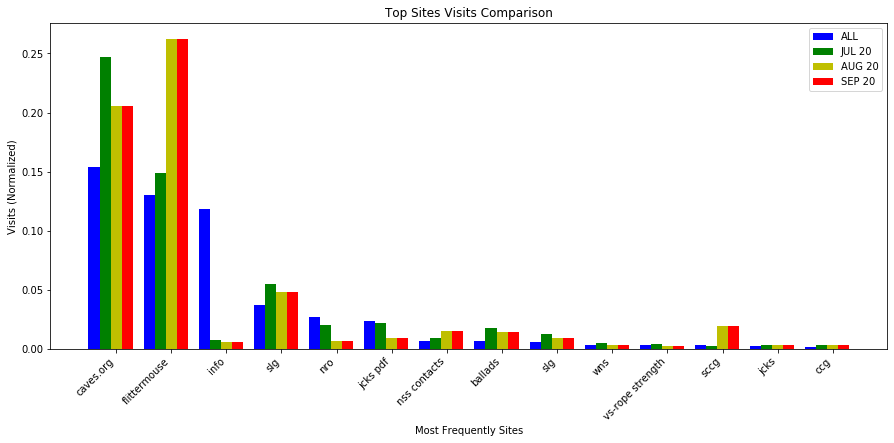

In [245]:
#bar chart comparison of july to overall

for i in range(len(x_labels)):
    print(f"{x_labels[i]}: 'caves.org{list(dir_dic_list[0].keys())[i]}'")
    
x = np.arange(0,len(x_labels))
x_labels = ['caves.org','flittermouse','info','slg','nro','jcks pdf','nss contacts',
            'ballads','slg','wns','vs-rope strength','sccg','jcks','ccg']
plt.figure(figsize=(15,6))
ax = plt.subplot(111)

all_plt = ax.bar(x-0.4, list(dir_dic_list[0].values()), width = 0.2, color = 'b', align = 'center')
jul_plt = ax.bar(x-0.2, list(dir_dic_list[1].values()), width = 0.2, color = 'g', align = 'center')
aug_plt = ax.bar(x, list(dir_dic_list[2].values()), width = 0.2, color = 'y', align = 'center')
sep_plt = ax.bar(x+0.2, list(dir_dic_list[3].values()), width = 0.2, color = 'r', align = 'center')

ax.legend((all_plt[0],jul_plt[0],aug_plt[0],sep_plt[0]), ('ALL', 'JUL 20', 'AUG 20','SEP 20') )
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha = 'right')

plt.title('Top Sites Visits Comparison')
plt.xlabel('Most Frequently Sites')
plt.ylabel('Visits (Normalized)')
plt.show()

Caves.org had a significant increase in traffic Jul-Sep.
Interestingly, caves.org/info decreased signficantly during this same time.

Flittermouse and SCCG had a significant increase in traffic in Aug-Sep. The other sites don't appear to have significant increases or decreases.

The driving factors in the increase of overall traffic from Aug-Sep seems to be:
* SLG referred traffic
* Flittermouse direct traffic (Aug-Sep)
* Caves.org direct traffic (Jul-Sep)

Perhaps SLG and Flittermouse had some kind of event during this time. I'd like to think the NSS Convention spurred the increase in traffic on the NSS main site during this timeframe.